In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress,levy,expon,pareto
from tqdm import tqdm  # For progress bars
import scipy.signal

# Set random seed for reproducibility
np.random.seed(42)

# Plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

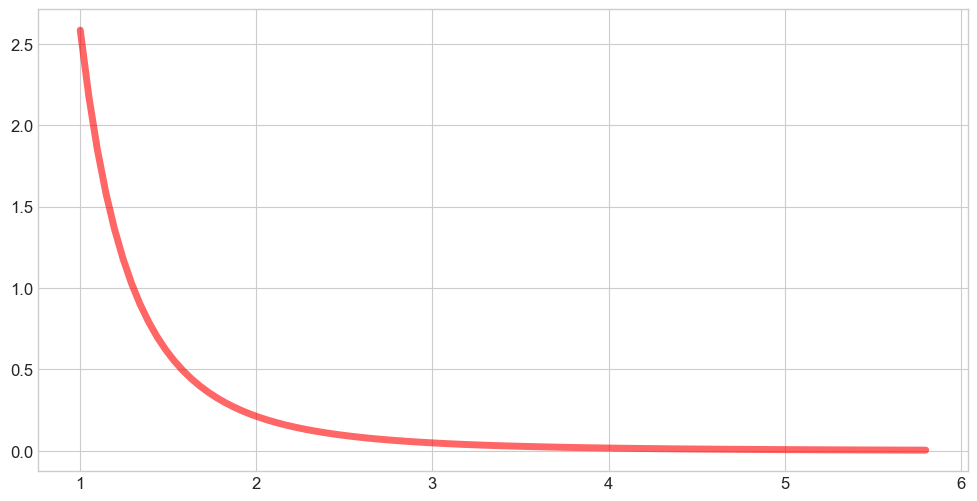

In [56]:
b = 2.62
lb, ub = pareto.support(b)
r = pareto.rvs(b=b,scale=8, size=1000)
x = np.linspace(pareto.ppf(0.01, b),
                pareto.ppf(0.99, b), 100)

plt.plot(x, pareto.pdf(x, b),
       'r-', lw=5, alpha=0.6, label='pareto pdf')
# plt.hist(r, density=True, bins='auto', histtype='stepfilled', alpha=0.2)
# plt.xlim([x[0], x[-1]])
plt.show()

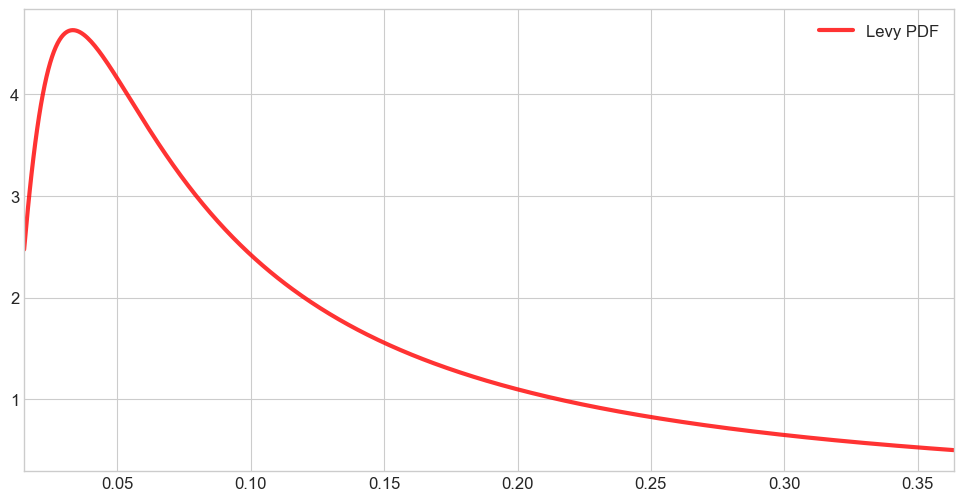

In [72]:
scale = 0.1

x = np.linspace(
    levy.ppf(0.01, scale=scale),   # avoid 0 → -inf
    levy.ppf(0.6, scale=scale),
    500
)

plt.plot(
    x,
    levy.pdf(x, scale=scale),      # MUST pass scale again
    'r-', lw=3, alpha=0.8, label='Levy PDF'
)

plt.xlim(x[0], x[-1])
plt.legend()
plt.show()

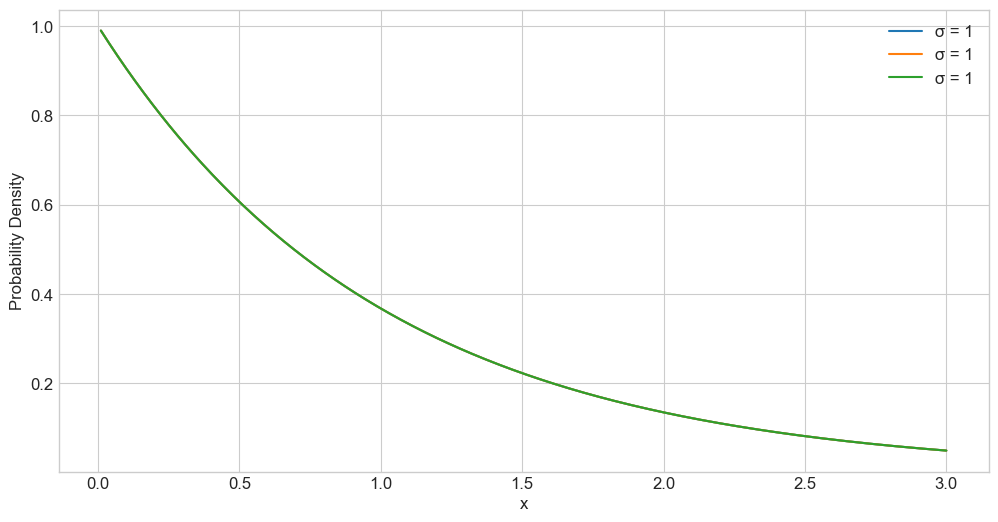

In [75]:
mu = 0
sigma = 1
alphas = [0.1, 0.3, 0.5]

x = np.linspace(0.01, 3, 500)

for a in alphas:
    rv = expon(loc=mu, scale=sigma)
    plt.plot(x, rv.pdf(x), label=f"σ = {sigma}")

plt.legend()
plt.xlabel("x")
plt.ylabel("Probability Density")
plt.show()

In [74]:

+9-def meanfield_simulation(N, K, T, B, return_full_history=False):
    """
    Simulates the delay evolution in a Mean Field (MF) approximation.
    
    Parameters:
    - N (int): Number of nodes (system components).
    - K (int): Number of inputs/neighbors per node.
    - T (int): Number of time steps.
    - B (float): Buffer size.
    - return_full_history (bool): If True, returns (N, T) matrix. 
                                  If False, returns (T,) vector of mean delays (memory efficient).
    
    Returns:
    - delays: Array of delays.
    """
    # Initialize state: Delays at t=0 are just the noise
    current_tau = np.random.exponential(scale=1.0, size=N)
    
    if return_full_history:
        history = np.zeros((N, T))
        history[:, 0] = current_tau
    else:
        # If we only need the mean delay per time step (for plots c and d)
        history = np.zeros(T)
        history[0] = np.mean(current_tau)

    # Simulation loop
    for t in range(1, T):
        # 1. Select random neighbors for all N nodes (MF assumption: reshuffled every step)
        # Shape: (N, K)
        neighbor_indices = np.random.randint(0, N, size=(N, K))
        
        # 2. Retrieve the delays of these neighbors from the previous step
        # Shape: (N, K)
        neighbor_delays = current_tau[neighbor_indices]
        
        # 3. Calculate the maximum delay among neighbors
        # Shape: (N,)
        max_neighbor_delay = np.max(neighbor_delays, axis=1)
        
        # 4. Apply Buffer B and Rectification (ReLU)
        # "positive_part" from Julia code
        buffered_delay = np.maximum(0, max_neighbor_delay - B)
        
        # 5. Add new intrinsic noise (epsilon)
        # epsilon = expon.rvs(scale=1, size=N)
        epsilon = levy.rvs(scale=0.5, size=N)
        # epsilon = pareto.rvs(b=8,size=N) / 8
        current_tau = buffered_delay + epsilon
        
        # Store results
        if return_full_history:
            history[:, t] = current_tau
        else:
            history[t] = np.mean(current_tau)
            
    return history

def get_order_parameter(mean_delays_series):
    """
    Calculates the order parameter v (velocity of delay growth).
    This corresponds to the slope of the mean delay vs time.
    
    We simply take the mean difference, equivalent to the slope 
    averaged over the simulation.
    """
    # Exclude the transient initial phase (first 10% of simulation)
    start_idx = int(len(mean_delays_series) * 0.1)
    return np.mean(np.diff(mean_delays_series[start_idx:]))

Running Phase Transition Sweep...


100%|██████████| 30/30 [00:44<00:00,  1.50s/it]
C:\Users\mfdan\miniconda3\Lib\site-packages\scipy\stats\_stats_py.py:10730: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
C:\Users\mfdan\miniconda3\Lib\site-packages\scipy\stats\_stats_py.py:10744: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
C:\Users\mfdan\miniconda3\Lib\site-packages\scipy\stats\_stats_py.py:10750: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


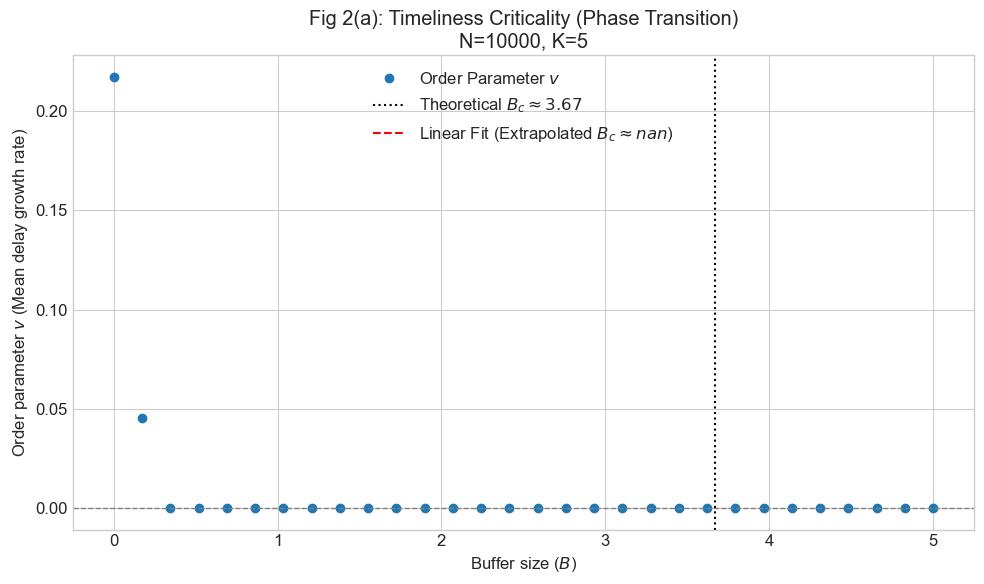

In [41]:
# Simulation Parameters
N = 10000     # Reduced slightly from 10k for speed, qualitative result is same
K = 5        # Number of neighbors
T = 2000     # Time steps
B_values = np.linspace(0, 5.0, 30) # Range of Buffers to test

velocities = []

print("Running Phase Transition Sweep...")
for B in tqdm(B_values):
    # Run simulation
    mean_delays = meanfield_simulation(N, K, T, B)
    
    # Calculate order parameter v (velocity)
    v = get_order_parameter(mean_delays)
    velocities.append(v)

# --- Calculate Critical Transition via Linear Fit ---
# Filter for the linear regime (where velocity is significantly above zero)
v_arr = np.array(velocities)
mask = v_arr > 0.05  # Adjust threshold if necessary
if np.any(mask):
    slope, intercept, r_value, p_value, std_err = linregress(B_values[mask], v_arr[mask])
    calculated_Bc = -intercept / slope
else:
    calculated_Bc = None

# --- Plotting Figure 2(a) ---
plt.figure(figsize=(10, 6))
plt.plot(B_values, velocities, 'o', markersize=6, color='#1f77b4', label='Order Parameter $v$')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

# Theoretical B_c
Bc_approx = 3.67
plt.axvline(Bc_approx, color='black', linestyle=':', label=f'Theoretical $B_c \\approx {Bc_approx}$')

# Plot Calculated Fit
if calculated_Bc:
    fit_x = np.linspace(B_values[mask][0], calculated_Bc, 50)
    plt.plot(fit_x, slope * fit_x + intercept, color='red', linestyle='--', 
             label=f'Linear Fit (Extrapolated $B_c \\approx {calculated_Bc:.3f}$)')
    plt.axvline(calculated_Bc, color='red', alpha=0.3)

plt.title(f'Fig 2(a): Timeliness Criticality (Phase Transition)\nN={N}, K={K}')
plt.xlabel('Buffer size ($B$)')
plt.ylabel('Order parameter $v$ (Mean delay growth rate)')
plt.legend()
plt.tight_layout()
plt.show()

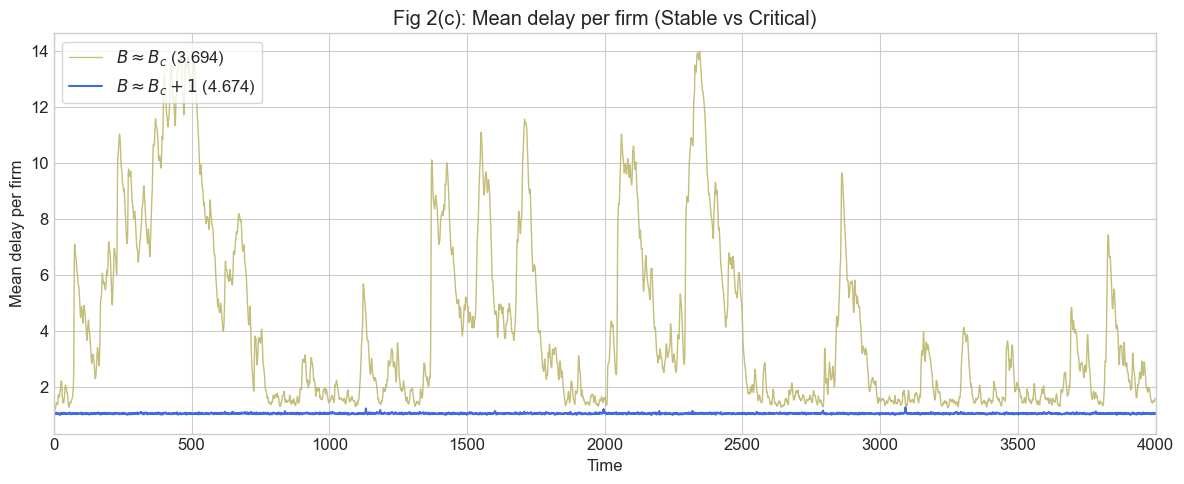

In [12]:
# Parameters matching the paper's context
N = 10000
K = 5
T = 4000
Bc = 3.674  # Critical buffer value

# Case 1: Close to criticality (from above)
B_critical = Bc + 0.02 
mean_delays_crit = meanfield_simulation(N, K, T, B_critical)

# Case 2: Safely stable
B_stable = Bc + 1.0
mean_delays_stable = meanfield_simulation(N, K, T, B_stable)

# --- Plotting Figure 2(c) ---
plt.figure(figsize=(12, 5))

plt.plot(mean_delays_crit, color='#bdb76b', linewidth=1, alpha=0.9, label=f'$B \\approx B_c$ ({B_critical:.3f})')
plt.plot(mean_delays_stable, color='#4169e1', linewidth=1.5, label=f'$B \\approx B_c + 1$ ({B_stable:.3f})')

plt.title('Fig 2(c): Mean delay per firm (Stable vs Critical)')
plt.xlabel('Time')
plt.ylabel('Mean delay per firm')
plt.legend(loc='upper left', frameon=True)
plt.xlim(0, T)
plt.tight_layout()
plt.show()

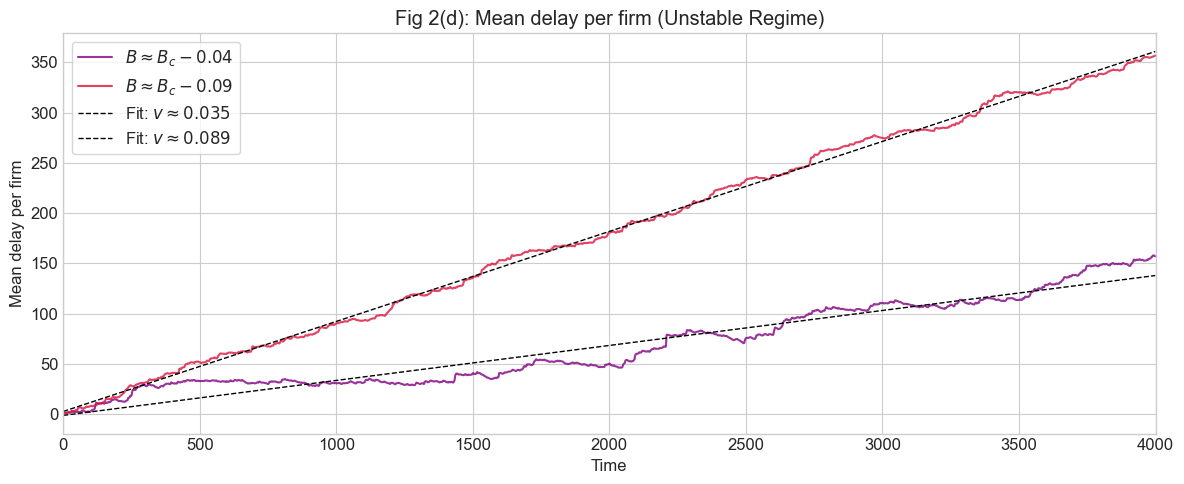

In [13]:
# Parameters
N = 10000
K = 5
T = 4000

# Case 1: Slightly unstable
B_unstable_1 = Bc - 0.04
mean_delays_u1 = meanfield_simulation(N, K, T, B_unstable_1)

# Case 2: More unstable
B_unstable_2 = Bc - 0.09
mean_delays_u2 = meanfield_simulation(N, K, T, B_unstable_2)

# Fit lines to get the exact slope (velocity v)
slope1, intercept1, _, _, _ = linregress(np.arange(T), mean_delays_u1)
slope2, intercept2, _, _, _ = linregress(np.arange(T), mean_delays_u2)

# --- Plotting Figure 2(d) ---
plt.figure(figsize=(12, 5))

# Plot Data
plt.plot(mean_delays_u1, color='#800080', linewidth=1.5, alpha=0.8, 
         label=f'$B \\approx B_c - 0.04$')
plt.plot(mean_delays_u2, color='#dc143c', linewidth=1.5, alpha=0.8, 
         label=f'$B \\approx B_c - 0.09$')

# Plot Fits
t_vals = np.arange(T)
plt.plot(t_vals, slope1 * t_vals + intercept1, color='black', linestyle='--', linewidth=1,
         label=f'Fit: $v \\approx {slope1:.3f}$')
plt.plot(t_vals, slope2 * t_vals + intercept2, color='black', linestyle='--', linewidth=1,
         label=f'Fit: $v \\approx {slope2:.3f}$')

plt.title('Fig 2(d): Mean delay per firm (Unstable Regime)')
plt.xlabel('Time')
plt.ylabel('Mean delay per firm')
plt.legend(loc='upper left', frameon=True)
plt.xlim(0, T)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.interpolate import interp1d
from scipy.optimize import minimize_scalar

# --- 1. Simulation Parameters ---
N = 10000          
K = 5              
T = 60000          # Slightly increased for better tail statistics
Bc_paper = 3.6755  # Critical value from paper 
B_list = [3.7107, 3.6979, 3.6894, 3.6837, 3.6799] 

# Reference B for data collapse (from paper Fig 3a caption )
B_ref_val = 3.6799

def run_simulation(N, K, T, B):
    """Optimized Mean-Field Simulation"""
    current_delays = np.random.exponential(1.0, N)
    mean_delay_history = np.zeros(T)
    
    for t in range(T):
        noise = np.random.exponential(1.0, N)
        predecessors = np.random.randint(0, N, (N, K))
        max_prev = np.max(current_delays[predecessors], axis=1)
        current_delays = np.maximum(0, max_prev - B) + noise
        mean_delay_history[t] = np.mean(current_delays)
        
    return mean_delay_history

# --- 2. Run Simulations ---
data_store = {}
print(f"Simulating (N={N}, T={T})...")

for B in tqdm(B_list):
    full_series = run_simulation(N, K, T, B)
    series = full_series[int(0.15*T):] # Discard burn-in
    
    # -- A. Autocorrelation (ACF) --
    fluc = series - np.mean(series)
    n = len(fluc)
    # FFT for efficiency
    f = np.fft.fft(fluc, n=2*n)
    acf = np.fft.ifft(f * np.conjugate(f))[:n].real
    acf /= acf[0]
    
    # -- B. Avalanches --
    is_avalanche = series > B
    padded = np.concatenate(([False], is_avalanche, [False]))
    diffs = np.diff(padded.astype(int))
    starts = np.where(diffs == 1)[0]
    ends = np.where(diffs == -1)[0]
    durations = ends - starts
    sizes = [np.sum(series[s:e] - B) for s, e in zip(starts, ends)]
            
    data_store[B] = {
        'acf': acf,
        'durations': durations,
        'sizes': np.array(sizes),
        'mean_tp': np.mean(durations) if len(durations) > 0 else np.nan,
        'mean_s': np.mean(sizes) if len(sizes) > 0 else np.nan
    }

# --- 3. Implement "Paper's Approach" for Collapse ---
# Goal: Find scale factor 'xi' for each curve to match the reference curve (B=3.6799)
# We minimize the difference between log(ACF_B(t)) and log(ACF_Ref(t * xi))

ref_data = data_store[B_ref_val]['acf']
x_ref = np.arange(len(ref_data))

# [FIX 1] Increased threshold to 0.05. 
# We only want to fit the "meat" of the curve, not the noisy tail.
valid_ref = (ref_data > 0.05) & (x_ref < len(ref_data)/5)
ref_interp = interp1d(x_ref[valid_ref], np.log(ref_data[valid_ref]), kind='linear', fill_value="extrapolate")

collapse_factors = {}

for B in B_list:
    if B == B_ref_val:
        collapse_factors[B] = 1.0
        continue
    
    target_acf = data_store[B]['acf']
    x_target = np.arange(len(target_acf))
    
    # Cost function: MSE between scaled target and reference
    def cost(scale_factor):
        # [FIX 2] Restrict target fitting range similarly (ACF > 0.05)
        # This ensures we are matching the decay slopes, not the noise floor.
        t_points = x_target[(target_acf > 0.05) & (x_target < len(x_target)/5)]
        
        if len(t_points) < 5: return 1e6
        
        # Map these t points to reference time
        t_mapped = t_points * scale_factor
        
        # Penalty if we map way outside our reference interpolation range
        if np.max(t_mapped) > np.max(x_ref[valid_ref]) * 1.5:
             return 1e6
        
        pred_log_acf = ref_interp(t_mapped)
        actual_log_acf = np.log(target_acf[t_points])
        
        return np.mean((pred_log_acf - actual_log_acf)**2)

    # Find optimal scaling factor relative to reference
    res = minimize_scalar(cost, bounds=(0.1, 50.0), method='bounded')
    collapse_factors[B] = 1.0 / res.x

# --- 4. Plotting ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(1, 3, figsize=(18, 5.5), constrained_layout=True)
colors = plt.cm.copper(np.linspace(0.8, 0.1, len(B_list)))

# === Plot A: Autocorrelation (Optimized Collapse) ===
ax1 = axes[0]
for i, B in enumerate(B_list):
    d = data_store[B]
    xi = collapse_factors[B]
    
    # Rescale time by the optimized factor xi
    t_scaled = np.arange(len(d['acf'])) / xi
    
    # [FIX 3] Clean plotting mask
    # Stop plotting once the correlation drops below a noise floor (e.g. 0.005)
    # This removes the "wonky" oscillations at the bottom of the log plot.
    clean_signal = d['acf'] > 0.005
    
    ax1.plot(t_scaled[clean_signal], d['acf'][clean_signal], color=colors[i], lw=2, label=f'B={B:.4f}')

ax1.set_yscale('log')
ax1.set_xlim(0, 6000) 
ax1.set_ylim(1e-3, 1.2)
ax1.set_xlabel(r'Rescaled Time ($t / \xi$)', fontsize=12)
ax1.set_ylabel(r'Autocorrelation $C(t)$', fontsize=12)
ax1.set_title('Fig 3(a): Optimized Data Collapse', fontweight='bold')
ax1.legend(fontsize=8, loc='lower left')

# Inset A: Scaling Factors vs B-Bc
ax1_in = ax1.inset_axes([0.55, 0.55, 0.4, 0.4])
dB = np.array(B_list) - Bc_paper
xis = np.array([collapse_factors[B] for B in B_list])

# The reference B=3.6799 has factor 1.0. We scale others relative to it.
# We normalized so B_ref is 1.0. 
ax1_in.plot(dB, xis, 'k+', markersize=8, markeredgewidth=2)

# Fit Power Law
if len(xis) > 1:
    log_dB = np.log(dB)
    log_xi = np.log(xis)
    m, c = np.polyfit(log_dB, log_xi, 1)
    ax1_in.plot(dB, np.exp(c) * dB**m, 'r--', lw=1.5)
    ax1_in.text(0.05, 0.1, f'$\gamma \\approx {-m:.2f}$', transform=ax1_in.transAxes, fontsize=8)

ax1_in.set_xlabel(r'$B - B_c$', fontsize=8)
ax1_in.set_ylabel(r'Scale Factor $\xi$', fontsize=8)
ax1_in.set_xscale('linear') # The paper inset x-axis is linear B (or B-Bc)
ax1_in.set_yscale('linear') # Paper inset y-axis looks linear or log? It's linear in Fig 3a inset.

# === Plot B: Persistence ===
ax2 = axes[1]
for i, B in enumerate(B_list):
    d = data_store[B]
    if len(d['durations']) == 0: continue
    bins = np.logspace(0, np.log10(max(d['durations'])), 20)
    counts, _ = np.histogram(d['durations'], bins=bins, density=True)
    centers = (bins[:-1] + bins[1:]) / 2
    ax2.loglog(centers[counts>0], counts[counts>0], 'v', color=colors[i], alpha=0.8)

x = np.logspace(0.5, 2.5, 10)
ax2.plot(x, 0.2*x**(-1.5), 'k-')
ax2.text(15, 0.05, r'$\sim t_p^{-3/2}$', fontsize=10)
ax2.set_title('Fig 3(b): Avalanche Duration', fontweight='bold')
ax2.set_xlabel(r'$t_p$', fontsize=12)
ax2.set_ylabel(r'$P(t_p)$', fontsize=12)

# Inset B
ax2_in = ax2.inset_axes([0.5, 0.55, 0.45, 0.4])
mean_tps = [data_store[B]['mean_tp'] for B in B_list]
ax2_in.loglog(dB, mean_tps, 'k+')
m, c = np.polyfit(np.log(dB), np.log(mean_tps), 1)
ax2_in.loglog(dB, np.exp(c)*dB**m, 'r--')
ax2_in.set_xlabel(r'$B - B_c$', fontsize=8)
ax2_in.set_ylabel(r'Mean $t_p$', fontsize=8)

# === Plot C: Size ===
ax3 = axes[2]
for i, B in enumerate(B_list):
    d = data_store[B]
    if len(d['sizes']) == 0: continue
    bins = np.logspace(np.log10(min(d['sizes'])), np.log10(max(d['sizes'])), 25)
    counts, _ = np.histogram(d['sizes'], bins=bins, density=True)
    centers = (bins[:-1] + bins[1:]) / 2
    ax3.loglog(centers[counts>0], counts[counts>0], '^', color=colors[i], alpha=0.8)

x = np.logspace(2, 5, 10)
ax3.plot(x, 0.5*x**(-0.32), 'k-')
ax3.text(500, 1e-1, r'$\sim s^{-0.32}$', fontsize=10)
ax3.set_title('Fig 3(c): Avalanche Size', fontweight='bold')
ax3.set_xlabel(r'$s$', fontsize=12)
ax3.set_ylabel(r'$P(s)$', fontsize=12)

# Inset C
ax3_in = ax3.inset_axes([0.5, 0.2, 0.45, 0.4])
mean_ss = [data_store[B]['mean_s'] for B in B_list]
ax3_in.loglog(dB, mean_ss, 'k+')
m, c = np.polyfit(np.log(dB), np.log(mean_ss), 1)
ax3_in.loglog(dB, np.exp(c)*dB**m, 'r--')
ax3_in.set_xlabel(r'$B - B_c$', fontsize=8)
ax3_in.set_ylabel(r'Mean $s$', fontsize=8)

plt.show()

<>:154: SyntaxWarning: invalid escape sequence '\g'
<>:154: SyntaxWarning: invalid escape sequence '\g'
/var/folders/sb/9skg3y6s7vg45s898mkptggh0000gn/T/ipykernel_18764/4286529221.py:154: SyntaxWarning: invalid escape sequence '\g'
  ax1_in.text(0.05, 0.1, f'$\gamma \\approx {-m:.2f}$', transform=ax1_in.transAxes, fontsize=8)


Simulating (N=10000, T=60000)...


 80%|████████  | 4/5 [02:13<00:33, 33.52s/it]